## Table of content
### 1.[Introduction](#1.-Introduction)  
### 2.[Data preprocessing](#2.-Data-preprocessing)  
###    &emsp;2.1.[Data load](#2.1.-Data-load)  
###    &emsp;2.2.[Time serie stationary](#2.2.-Time-serie-stationary)  
###    &emsp;2.3.[Autocorrelation testing](#2.3.-Autocorrelation-testing)  
###    &emsp;2.4.[ARIMA modeling](#2.4.-ARIMA-Modeling)  
### 3.[Summary](#3.-Summary)

## 1. Introduction


#### Libraries import

In [215]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.style.use('fivethirtyeight')

## 2. Data preprocessing

### 2.1. Data load

#### Load dataset and formed it as relevant format dataframe

In [216]:
data = pd.read_csv('https://raw.githubusercontent.com/thaibao1306/A-Time-Series-Analysis/main/monthly_champagne_sales.csv',
                  parse_dates=True).squeeze()
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace =True, drop= True)
data.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


<AxesSubplot:xlabel='Month'>

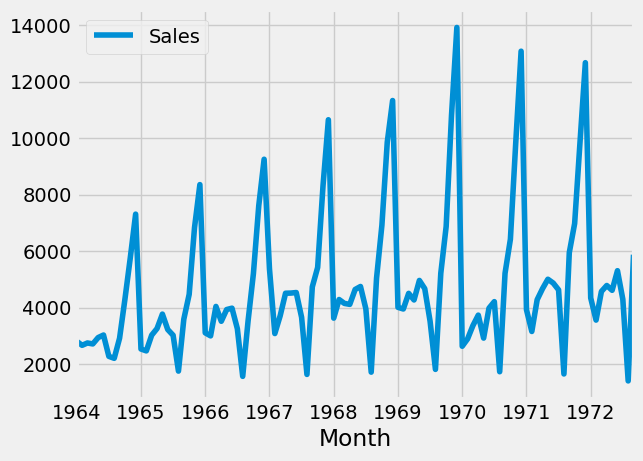

In [218]:
data.plot()

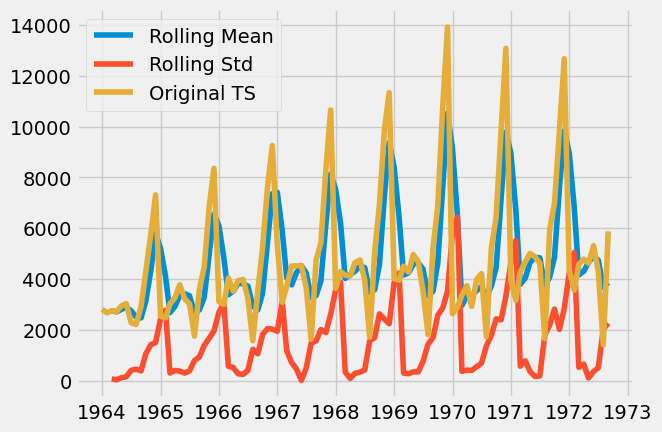

In [219]:
def rolling(ts, window = 1):
    rolling_mean  = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.plot(rolling_mean, label ='Rolling Mean')
    plt.plot(rolling_std, label ='Rolling Std')
    plt.plot(ts, label = 'Original TS')
    plt.legend()
rolling(data, window=3)

#### Drawing a Boxplot

<AxesSubplot:>

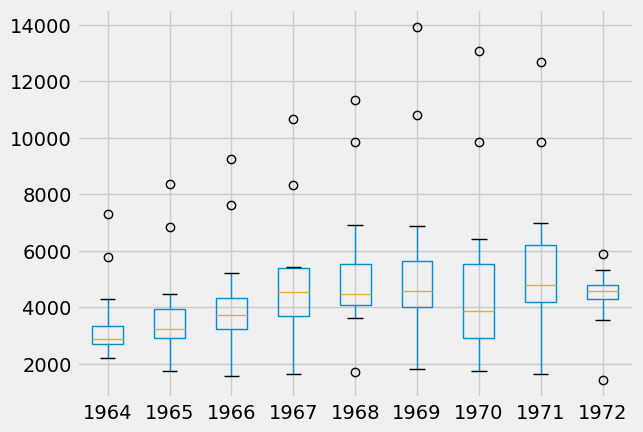

In [220]:
dummy_df = pd.DataFrame()
grouper = data.groupby(pd.Grouper(freq ='A'))
for n, g in grouper:
    dummy_df[n.year] = g.reset_index(drop=True)
dummy_df.boxplot()

#### Summary:  
#### The charts show that data might contain seasonality, trend with variable in average over the time

### 2.2. Time serie stationary

We going to use ARIMA model to predict the sales. One important assumption of this model is the time series stationary.
Testing method: Dickey-Fuller Test


In [221]:
adfuller(data)
def Dickey_fuller_test(time_series):
    dftest = adfuller(time_series)
    result = 'Not Stationary'
    if dftest[0] < dftest[4]['1%']:
        result ='Stationary'
    print('DF Test Result: %s'%result)
    names = ['Test-statistic', 'P-value','Lags Used', 'Number of Observation']
    out_put = pd.Series(dftest[:4], index=names)
    for key, item in dftest[4].items():
        out_put['Critical value %s:'%key] = item
    print(out_put)
Dickey_fuller_test(data)

DF Test Result: Not Stationary
Test-statistic           -1.833593
P-value                   0.363916
Lags Used                11.000000
Number of Observation    93.000000
Critical value 1%:       -3.502705
Critical value 5%:       -2.893158
Critical value 10%:      -2.583637
dtype: float64


#### Resuls of DF test indicates that the data is a unit root. So we apply some technical transformation to shifted the time series. 
#### Data given by month
#### By differencing with window =12 (months), DF test shows that P-value is small inferring that the time series is stationary at differencing  
#### window = 12 (basing all the assumption that the sales  have strong seanality, we will check this in next steps)

In [222]:
data_diff_1 =  data -data.shift(12)
data_diff_1.dropna(inplace=True)
Dickey_fuller_test(data_diff_1.dropna())

DF Test Result: Stationary
Test-statistic          -7.626619e+00
P-value                  2.060580e-11
Lags Used                0.000000e+00
Number of Observation    9.200000e+01
Critical value 1%:      -3.503515e+00
Critical value 5%:      -2.893508e+00
Critical value 10%:     -2.583824e+00
dtype: float64


##### Checking the plot, it seems to be variance increase by time at tail.

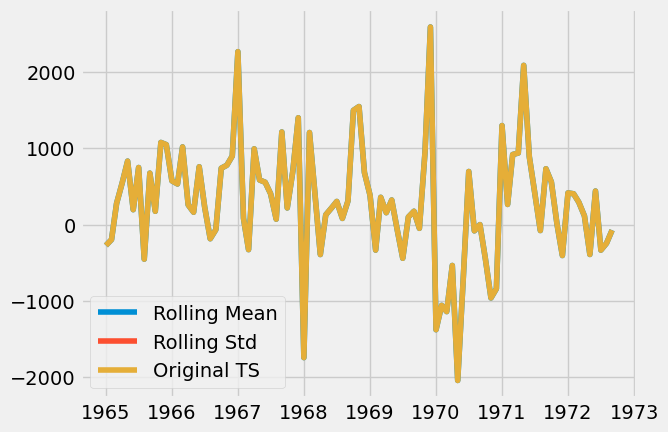

In [223]:
rolling(data_diff_1)

##### We try to remove the trend, seasonality

In [224]:
data_log = np.log(data)
ts_decompose = seasonal_decompose(data_log)
trend_element= ts_decompose.trend
seasonal_element = ts_decompose.seasonal
residual_element = ts_decompose.resid

#### Looking at the time serie seasonality

<AxesSubplot:xlabel='Month'>

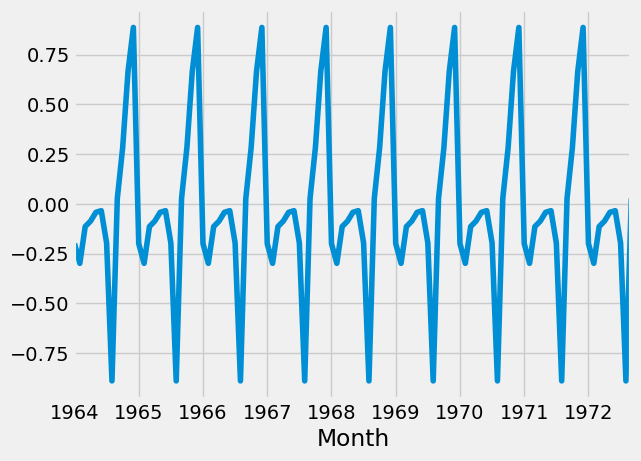

In [225]:
seasonal_element.plot()

#### Let zoom in

(array([  0.,  90., 181., 273., 365., 455., 546., 638., 730.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

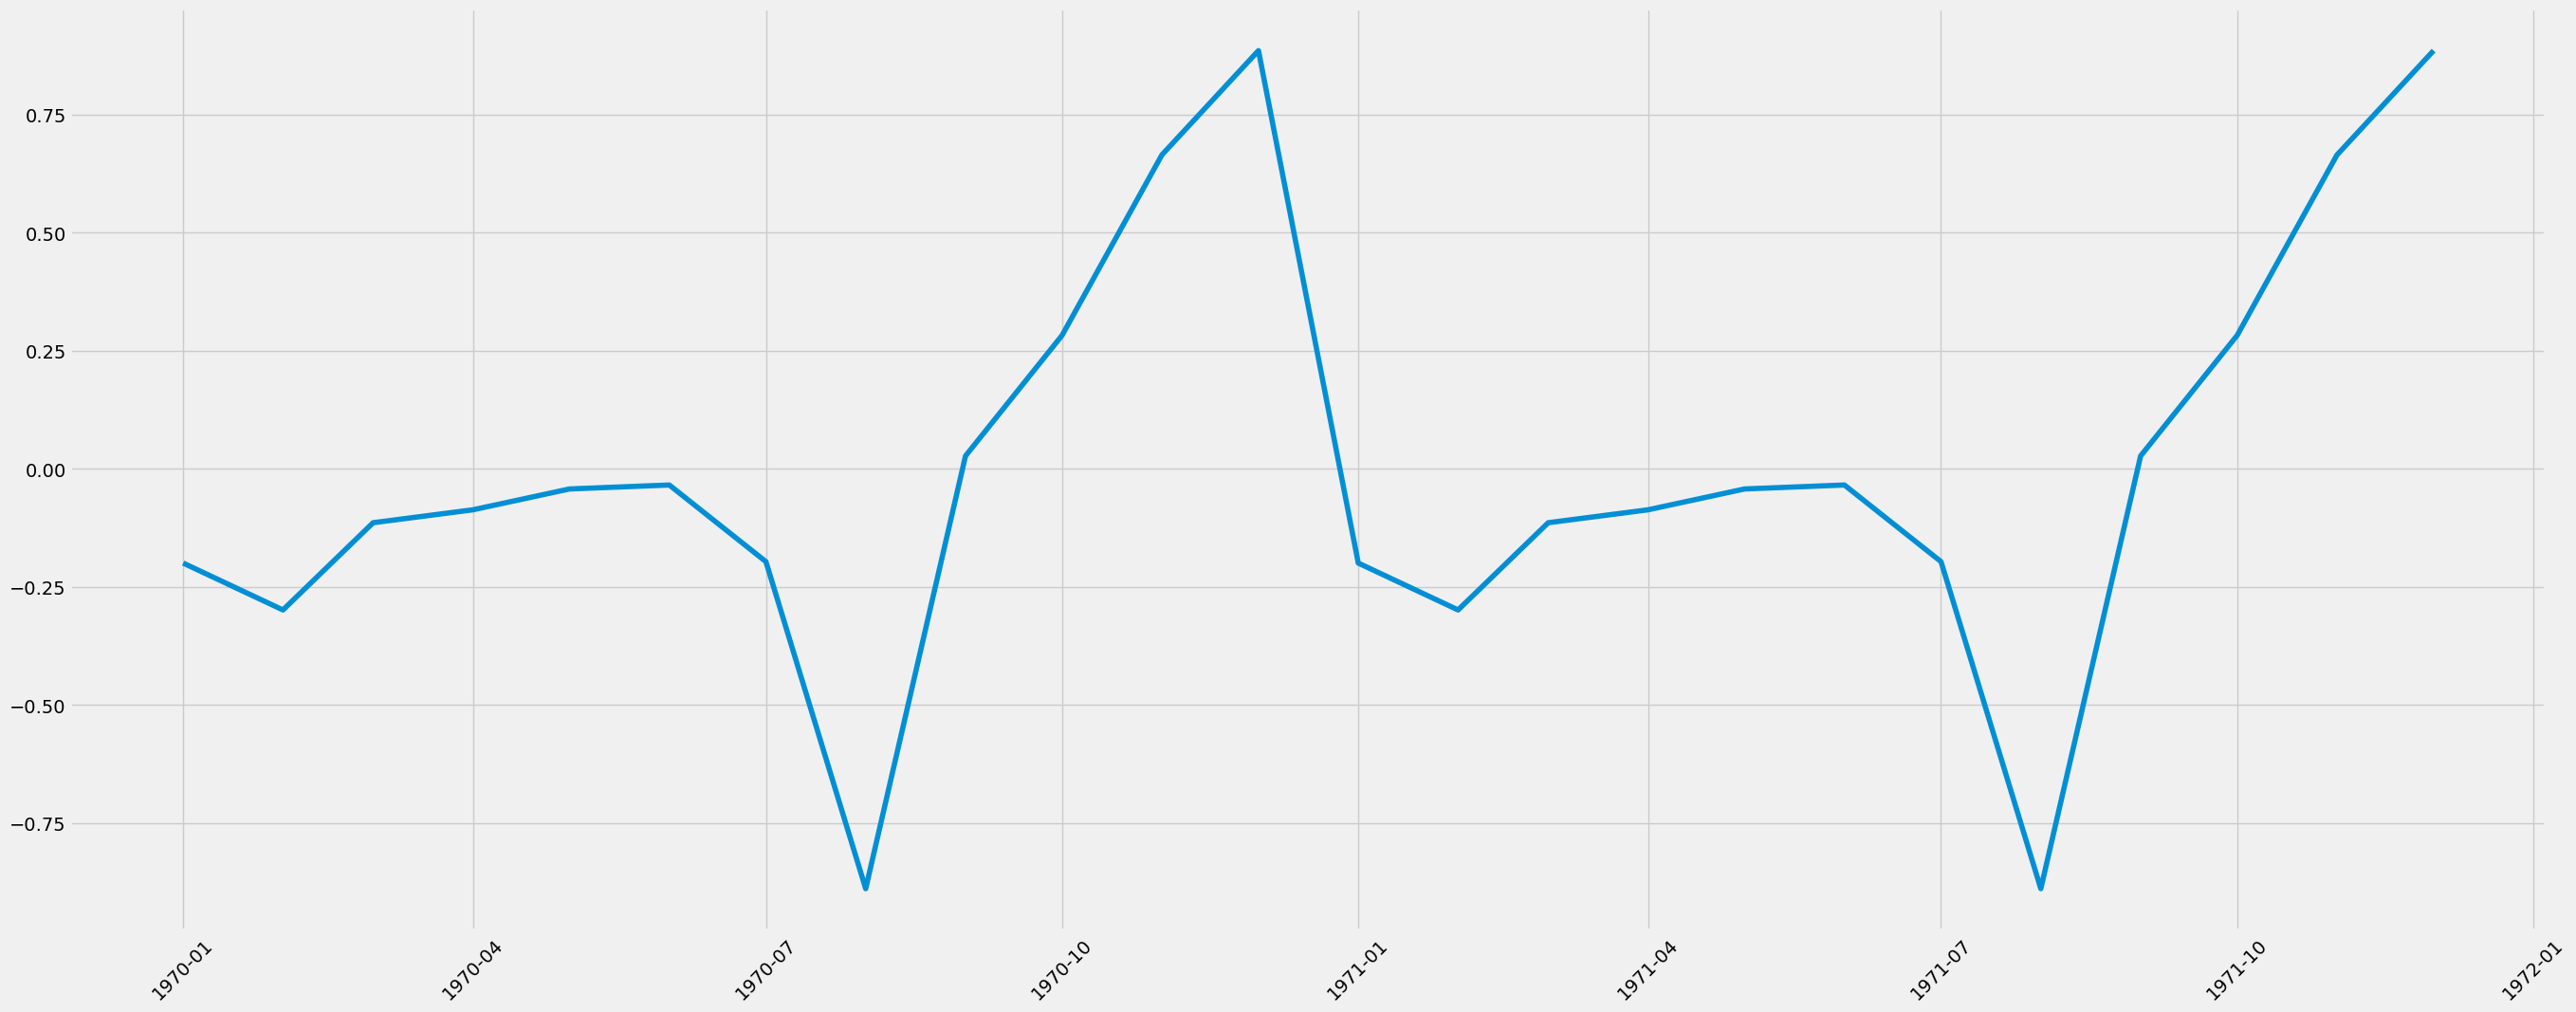

In [226]:
plt.figure(figsize=(30,12))
plt.plot(seasonal_element['1970':'1971'])
plt.xticks(rotation =45)


#### There was a seasonality interval of 12 months, so we will use Differencing with window =12 months

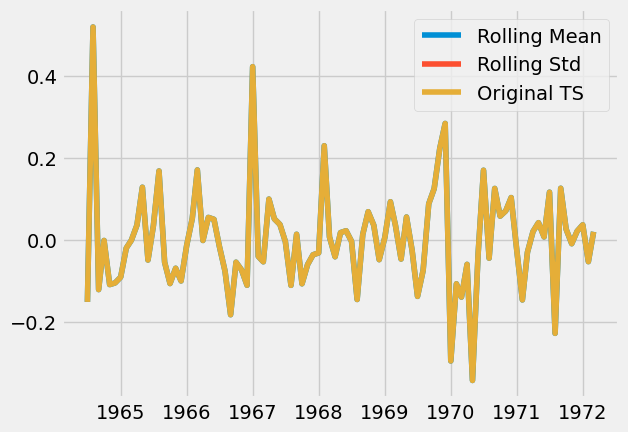

In [227]:
rolling(residual_element, window=1)

### 2.3. Autocorrelation testing

#### Autocorrelation Function/ Partial Autocorrelation Function correlograms


C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


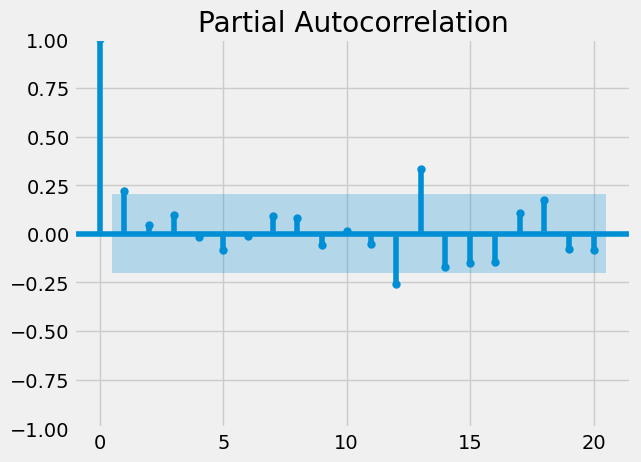

In [228]:
plot_pacf(data_diff_1);

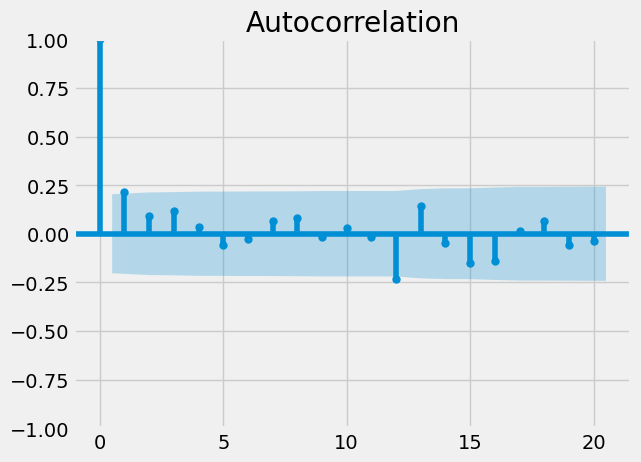

In [229]:
plot_acf(data_diff_1);

#### Let check for Durbin Wason

In [231]:
durbin_watson(data_diff_1)

array([1.36497326])

#### This number indicate that our data have significant negative autocorrelation

### 2.4. ARIMA modeling

#### Spliting dataset

#### From the correlograms, we decided p= 2, q=1, d=1 for ARIMA model

In [232]:
train = data_diff_1.iloc[:-10,0].values
test = data_diff_1.iloc[-10:,0].values
model  = ARIMA(train, order=(2,1,1))
model_fit = model.fit()

In [233]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   83
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -663.441
Date:                Sun, 06 Nov 2022   AIC                           1334.883
Time:                        13:49:25   BIC                           1344.509
Sample:                             0   HQIC                          1338.748
                                 - 83                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2121      0.087      2.438      0.015       0.042       0.383
ar.L2          0.0578      0.111      0.518      0.604      -0.161       0.276
ma.L1         -0.9997      2.264     -0.441      0.659      -5.438       3.438
sigma2      5.978e+05   1.34e+06      0.445      0.657   -2.04e+06    3.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 9.43
Prob(Q):                              0.91   Prob(JB):                         0.01
Heteroskedasticity (H):               2.86   Skew:                            -0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [234]:
history = [x for x in data.iloc[:-12,0].values]
yhat = list()
for i , x  in enumerate(predictions):
    y = x + history[i]
    yhat.append(y)

### 3. Summary

#### Ploting forecast and validation

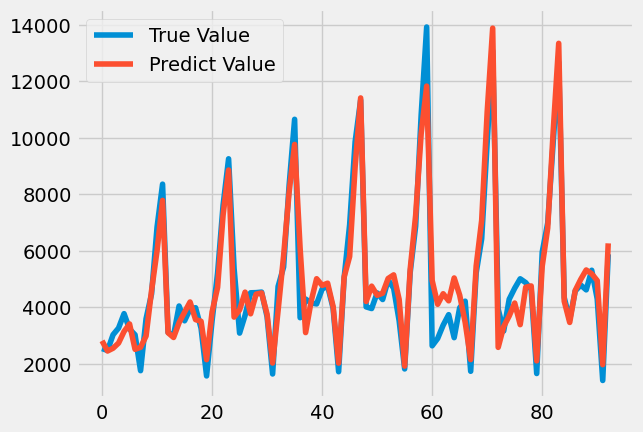

In [235]:
plt.plot(data.iloc[12:,0].values, label='True Value')
plt.plot(yhat, label='Predict Value')
plt.legend()
plt.show()

#### Model Evaluation:

In [236]:
print('Mean Forecast Error: %.2f'%((data.iloc[-10:,0].values- yhat[-10:]).mean()))
print('Mean Absolut Error: %.2f'% mean_absolute_error(data.iloc[-10:,0].values, yhat[-10:]))

Mean Forecast Error: -282.65
Mean Absolut Error: 353.50


#### The visualization and metrics of model shows that it's relatively accurate and predictable for next few months.